In [ ]:
!pip install optuna


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 404.7/404.7 kB 6.3 MB/s eta 0:00:00


[I 2025-11-19 18:16:31,262] A new study created in memory with name: no-name-0a6c6123-499b-4753-a753-ff9211ff0c17


[LOF] Muestras: 337 → 320 (removidos 17)
🚀 Iniciando optimización corregida con Optuna...


  0%|          | 0/40 [00:00<?, ?it/s]

[I 2025-11-19 18:16:31,293] Trial 0 finished with value: 1354240.2808057615 and parameters: {'C': 437.99200221532953, 'gamma': 0.0005781617897388124, 'epsilon': 0.17143490787543475}. Best is trial 0 with value: 1354240.2808057615.
[I 2025-11-19 18:16:31,307] Trial 1 finished with value: 1953671.3164673336 and parameters: {'C': 5.094403745213517, 'gamma': 0.00010510415956677329, 'epsilon': 0.6822125214574608}. Best is trial 0 with value: 1354240.2808057615.
[I 2025-11-19 18:16:31,323] Trial 2 finished with value: 1953389.8781796866 and parameters: {'C': 0.11155075167281744, 'gamma': 0.008470218839352454, 'epsilon': 0.1549918657704993}. Best is trial 0 with value: 1354240.2808057615.
[I 2025-11-19 18:16:31,336] Trial 3 finished with value: 871800.5819097378 and parameters: {'C': 405.3670625155415, 'gamma': 0.2319187175440073, 'epsilon': 0.9374376790900261}. Best is trial 3 with value: 871800.5819097378.
[I 2025-11-19 18:16:31,349] Trial 4 finished with value: 1951185.5302836963 and param

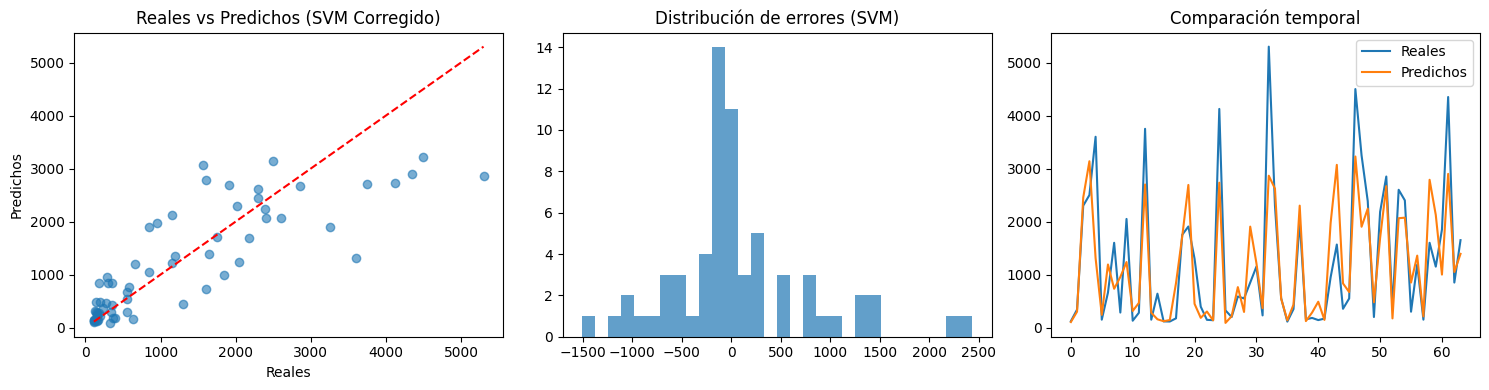

In [ ]:
# ================================================
# 🔹 MODELO SVM OPTIMIZADO
# ================================================

import time
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import optuna

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import SVR

# ---------------- DATASET ----------------
url = "https://raw.githubusercontent.com/Alisser2001/QuantumMachineLearning/emmadev/baseball.dat"
resp = requests.get(url)
lines = [line.strip() for line in resp.text.splitlines()]
attributes = [line.split()[1] for line in lines if line.startswith("@attribute")]
data_start = lines.index("@data") + 1
data = [line.split(",") for line in lines[data_start:] if line]
df = pd.DataFrame(data, columns=attributes).astype(float)

X_full, y_full = df.drop(columns=["Salary"]).values, df["Salary"].values

# 🔹 Solo StandardScaler (corregido)
sc_raw = StandardScaler().fit(X_full)
X_scaled = sc_raw.transform(X_full)

# 🔹 Outliers (LOF)
mask = LocalOutlierFactor(n_neighbors=20, contamination=0.05).fit_predict(X_scaled) == 1
X, y = X_scaled[mask], y_full[mask]

print(f"[LOF] Muestras: {len(df)} → {len(X)} (removidos {len(df)-len(X)})")

X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.2, random_state=42)

# ============================================
# 🔍 OPTIMIZACIÓN CON OPTUNA
# ============================================

def objective(trial):

    # SVM hyperparameters
    C = trial.suggest_float("C", 0.1, 1000, log=True)
    gamma = trial.suggest_float("gamma", 1e-4, 1.0, log=True)
    epsilon = trial.suggest_float("epsilon", 0.001, 1.0)

    model = SVR(kernel="rbf", C=C, gamma=gamma, epsilon=epsilon)

    model.fit(X_tr, y_tr)
    preds = model.predict(X_te)

    mse = mean_squared_error(y_te, preds)
    return mse

print("🚀 Iniciando optimización corregida con Optuna...")
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=40, show_progress_bar=True)

print("\n🏆 Mejor configuración encontrada (corregida):")
print(study.best_params)

# ===================================================
# 🔹 ENTRENAMIENTO FINAL
# ===================================================
best = study.best_params

modelo_final = SVR(
    kernel="rbf",
    C=best["C"],
    gamma=best["gamma"],
    epsilon=best["epsilon"]
)

t0 = time.time()
modelo_final.fit(X_tr, y_tr)
y_pred = modelo_final.predict(X_te)
t1 = time.time()

mse = mean_squared_error(y_te, y_pred)
r2 = r2_score(y_te, y_pred)

print("\n📊 Resultados finales del modelo SVM CORREGIDO:")
print(f"MSE: {mse:.6f}")
print(f"R²: {r2:.6f}")
print(f"Tiempo total: {t1 - t0:.3f} s")

# ===================================================
# 📈 VISUALIZACIONES DE RESULTADOS
# ===================================================

plt.figure(figsize=(15, 4))

# 1️⃣ Reales vs Predicciones
plt.subplot(1, 3, 1)
plt.scatter(y_te, y_pred, alpha=0.6)
plt.plot([y_te.min(), y_te.max()], [y_te.min(), y_te.max()], 'r--')
plt.xlabel("Reales")
plt.ylabel("Predichos")
plt.title("Reales vs Predichos (SVM Corregido)")

# 2️⃣ Histograma de errores
plt.subplot(1, 3, 2)
errores = y_te - y_pred
plt.hist(errores, bins=30, alpha=0.7)
plt.title("Distribución de errores (SVM)")

# 3️⃣ Gráfico temporal
plt.subplot(1, 3, 3)
plt.plot(y_te[:200], label="Reales")
plt.plot(y_pred[:200], label="Predichos")
plt.title("Comparación temporal")
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
# ================================================
# 🔹 MLP REGRESSOR OPTIMIZADO CON OPTUNA
# ================================================

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.neural_network import MLPRegressor
import optuna
import warnings
import requests

from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=ConvergenceWarning)

# =============================
# 1️⃣ CARGA DEL DATASET ARFF
# =============================
url = "https://raw.githubusercontent.com/Alisser2001/QuantumMachineLearning/emmadev/baseball.dat"
resp = requests.get(url)

lines = [line.strip() for line in resp.text.splitlines()]

# Obtener nombres de atributos
attributes = [line.split()[1] for line in lines if line.startswith("@attribute")]

# Obtener datos después de @data
data_start = lines.index("@data") + 1
data = [line.split(",") for line in lines[data_start:] if line]

# Crear DataFrame
df = pd.DataFrame(data, columns=attributes).astype(float)

# =============================
# Separar características y target
# =============================
target_col = "Salary"

X = df.drop(columns=[target_col]).values
y = df[target_col].values

# Escalado
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)

# =============================
# 2️⃣ FUNCIÓN OBJETIVO OPTUNA
# =============================
def objective(trial):
    n_layers = trial.suggest_int("n_layers", 1, 3)
    layer_size = trial.suggest_int("layer_size", 10, 100)
    solver = trial.suggest_categorical("solver", ["adam", "lbfgs"])
    alpha = trial.suggest_float("alpha", 1e-5, 1e-2, log=True)
    learning_rate_init = trial.suggest_float("learning_rate_init", 1e-4, 1e-1, log=True)

    hidden = tuple([layer_size] * n_layers)

    if solver == "adam":
        model = MLPRegressor(hidden_layer_sizes=hidden,
                             solver="adam",
                             alpha=alpha,
                             learning_rate_init=learning_rate_init,
                             max_iter=2000,
                             random_state=42)
    else:
        model = MLPRegressor(hidden_layer_sizes=hidden,
                             solver="lbfgs",
                             alpha=alpha,
                             max_iter=2000,
                             random_state=42)

    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    mse = mean_squared_error(y_test, preds)
    return mse

# =============================
# 3️⃣ OPTIMIZACIÓN
# =============================
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=30)

print("🔎 Mejor configuración:")
print(study.best_params)

# =============================
# 4️⃣ ENTRENAMIENTO FINAL
# =============================
best = study.best_params

hidden = tuple([best["layer_size"]] * best["n_layers"])

if best["solver"] == "adam":
    final_model = MLPRegressor(
        hidden_layer_sizes=hidden,
        solver="adam",
        alpha=best["alpha"],
        learning_rate_init=best["learning_rate_init"],
        max_iter=2000,
        random_state=42
    )
else:
    final_model = MLPRegressor(
        hidden_layer_sizes=hidden,
        solver="lbfgs",
        alpha=best["alpha"],
        max_iter=2000,
        random_state=42
    )

final_model.fit(X_train, y_train)
y_pred = final_model.predict(X_test)

print(f"R²: {r2_score(y_test, y_pred):.4f}")
print(f"MSE: {mean_squared_error(y_test, y_pred):.6f}")


[I 2025-11-19 18:19:45,692] A new study created in memory with name: no-name-5d735fff-c647-4a36-9562-4c528c7f208f
[I 2025-11-19 18:19:47,131] Trial 0 finished with value: 758579.2916198736 and parameters: {'n_layers': 1, 'layer_size': 40, 'solver': 'adam', 'alpha': 0.00014550967617721068, 'learning_rate_init': 0.0009071360571825378}. Best is trial 0 with value: 758579.2916198736.
[I 2025-11-19 18:19:49,776] Trial 1 finished with value: 3004640.6145358547 and parameters: {'n_layers': 1, 'layer_size': 94, 'solver': 'lbfgs', 'alpha': 0.0009410608206203827, 'learning_rate_init': 0.00020009619538377551}. Best is trial 0 with value: 758579.2916198736.
[I 2025-11-19 18:19:53,321] Trial 2 finished with value: 1004146.0141200314 and parameters: {'n_layers': 3, 'layer_size': 29, 'solver': 'lbfgs', 'alpha': 0.00034995577345239804, 'learning_rate_init': 0.05317398365731132}. Best is trial 0 with value: 758579.2916198736.
[I 2025-11-19 18:19:56,320] Trial 3 finished with value: 2167475.073758312 an

🔎 Mejor configuración:
{'n_layers': 3, 'layer_size': 54, 'solver': 'adam', 'alpha': 0.0006282453840969549, 'learning_rate_init': 0.0007703493474536095}
R²: 0.7357
MSE: 388406.042095


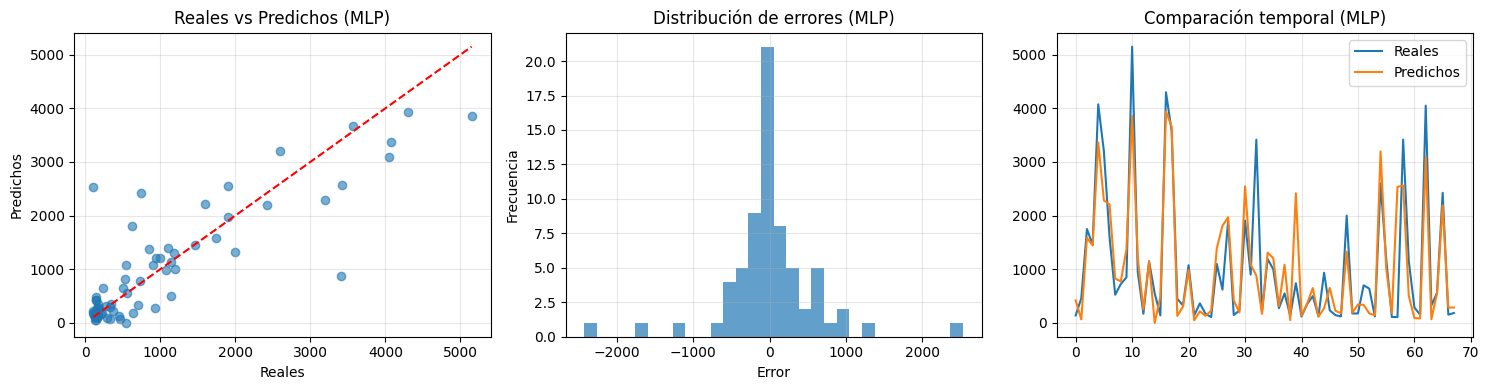

In [ ]:
# ===================================================
# 📈 VISUALIZACIONES DE RESULTADOS — MLP
# ===================================================

import matplotlib.pyplot as plt

plt.figure(figsize=(15, 4))

# 1️⃣ Reales vs Predicciones
plt.subplot(1, 3, 1)
plt.scatter(y_test, y_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Reales")
plt.ylabel("Predichos")
plt.title("Reales vs Predichos (MLP)")
plt.grid(True, alpha=0.3)

# 2️⃣ Histograma de errores
plt.subplot(1, 3, 2)
errores = y_test - y_pred
plt.hist(errores, bins=30, alpha=0.7)
plt.title("Distribución de errores (MLP)")
plt.xlabel("Error")
plt.ylabel("Frecuencia")
plt.grid(True, alpha=0.3)

# 3️⃣ Gráfico temporal
plt.subplot(1, 3, 3)
plt.plot(y_test[:200], label="Reales")
plt.plot(y_pred[:200], label="Predichos")
plt.title("Comparación temporal (MLP)")
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()
